## Multi-scale Residual Dense Network

---



## The below network I am going to implement.

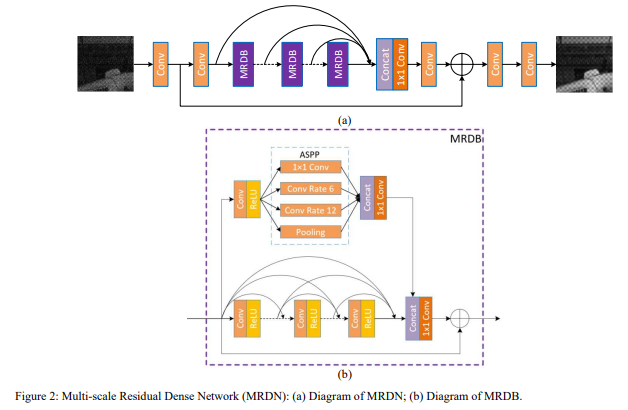

In [ ]:
load_img('/content/drive/MyDrive/Colab Notebooks/noise_clean_data/MRDN.PNG')

Related papers<br>
https://arxiv.org/pdf/2005.04117.pdf    this paper presents more than 10 architectures used for real world image denoising as part of competion in 2020. I am using architecture which won the second rank .<br> 

Research paper  I am using the architecture from can be found in the below link<br>
https://openaccess.thecvf.com/content_CVPRW_2020/papers/w31/Bao_Real_Image_Denoising_Based_on_Multi-Scale_Residual_Dense_Block_and_CVPRW_2020_paper.pdf


#### Explanation<br>
Real Image Denoising based on Multi-scale Residual Dense Block.  MRDN architecture is proposed by the Samsung SLSI MSL team in the competion 'NTIRE 2020 Challenge on Real Image Denoising'.<br>

The Multi-scale Residual Dense Network (MRDN) is 
based on a new basic module, the Multi-scale Residual 
Dense Block (MRDB), as shown in Fig. 2 (a). MRDB 
combines multi-scale features from the ASPP and other 
features from the traditional residual dense block (RDB). 
As shown in Fig. 2 (b), the ASPP  contains four 
parallel network blocks including conv 1×1, conv Rate 6, 
conv Rate 12 and pooling. The conv Rate 6 and conv Rate 
12 denote the 3×3 dilated convolutions with the dilation rate 
of 6 and 12, respectively. Conv Rate 6, conv Rate 12 and 
image pooling can well capture the multi-scale features of 
the block input. The features outputted from the ASPP are 
concatenated and compressed to be combined with other 
features from the RDB. To have a seamless local residual 
connection, this concatenated feature is compressed with 
another conv 1×1 before an element-wise adder. 
The output of the MRDB preserves the same number of 
channels of its input to avoid the exponential complexity 
increase. With the MRDB as a building module, the MRDN 
constructs the network using the similar way as the residual 
dense network (RDN) by cascading the MRDBs with 
dense connections. Specifically, the outputs of the MRDBs 
are concatenated and compressed with a conv 1×1, and a 
global residual connection is adopted to obtain clean 
features. 



In [1]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout
from keras.layers import Input,Conv2D
from keras import backend as K
import numpy as np
from keras.layers import BatchNormalization,Activation,Subtract,Add,concatenate
from keras.layers import Conv2D, MaxPooling2D,Dropout,Lambda,PReLU,LeakyReLU,AveragePooling2D
from keras.optimizers import Adam
import keras
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
from tensorflow.image import psnr
from tensorflow.image import ssim 
from keras.callbacks import  LearningRateScheduler,ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model
import glob
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import os
from tqdm.notebook import tqdm
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from skimage.util import img_as_ubyte




In [2]:
#mounting the google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#os.chdir('/content/drive/MyDrive/Colab Notebooks/noise_clean_data')

In [3]:
#current directory
os.chdir('/content')
root_path='/content'
#root_path='/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset'
#os.chdir('/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset')

In [4]:
#This function used to download from my google drive to colab disk
#https://stackoverflow.com/questions/48735600/file-download-from-google-drive-to-colaboratory
!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_train_clean/' '/content/resized_train_clean'
!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_train_noisy/' '/content/resized_train_noisy'
!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_test_clean/' '/content/resized_test_clean'
!cp -r '/content/drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/resized_test_noisy/' '/content/resized_test_noisy' 

### Model architecture begins here

In [5]:
#https://medium.com/mlearning-ai/image-super-resolution-using-edsr-and-wdsr-f4de0b00e039
########################################## EDSR MODEL #####################################
def EDSR(scale, num_filters=256, res_blocks=8, res_block_scaling=None):
    x_input = Input(shape=(256, 256, 3))
    # Normalize input with DIV2K_RGB_MEAN
    #x = Lambda(normalize)(x_input)
    #x=    Conv2D(num_filters, 3, padding='same')(x_input)
    # assign value of x to x_res block for further operations
    x = x_res_block = Conv2D(num_filters, 3, padding='same')(x_input)

    # Goes in number of res block
    for i in range(res_blocks):
        x_res_block = ResBlock(x_res_block, num_filters, res_block_scaling)
    # convolution
    x_res_block = Conv2D(num_filters, 3, padding='same',kernel_initializer='he_normal')(x_res_block)
    x_res_block=LeakyReLU(alpha=0.1)(x_res_block)

    # add res_block output and original normalizwd input
    x = Add()([x, x_res_block])

    # upsampling
    x = Upsampling(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)
    x=AveragePooling2D(pool_size=(2,2),strides=(2,2),padding='same')(x)



    #x = Downsampling(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    
    # denormalize to get back original form
    #x = Lambda(denormalize)(x)
    return Model(x_input, x, name="EDSR")
  
################################## ResBlock Architecture ################################
def ResBlock(x_input, num_filters, scaling):
    '''This function Implementes Proposed ResBlock Architecture as per EDSR paper'''
    # proposed ResBlock ==> Conv --> Relu --> Conv --> Scaling(mul) --> Add
    x = Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(x_input)
    x=LeakyReLU(alpha=0.1)(x)
    x = Conv2D(num_filters, 3, padding='same',kernel_initializer='he_normal')(x)
    x=LeakyReLU(alpha=0.1)(x)
    x=AveragePooling2D(pool_size=(2,2),strides=(1,1),padding='same')(x)

    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_input, x])
    return x
######################################### Upsampling #######################################
def Upsampling(x, scale, num_filters):
    '''This function upsampling as mentioned in EDSR paper'''
    def upsample(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(shuffle_pixels(scale=factor))(x)

    if scale == 2:
        x = upsample(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample(x, 2, name='conv2d_1_scale_2')
        x = upsample(x, 2, name='conv2d_2_scale_2')

    return x

def Downsampling(x, scale, num_filters):
    '''This function upsampling as mentioned in EDSR paper'''
    def downsample(x, factor, **kwargs):
        x = Conv2D(num_filters *(factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(reshuffle_pixels(scale=factor))(x)
    
    if scale == 2:
        x = downsample(x, 2, name='conv2d_1_scaled_2')
    elif scale == 3:
        x = downsample(x, 3, name='conv2d_1_scaled_3')
    elif scale == 4:
        x = downsample(x, 2, name='conv2d_1_scaled_2')
        x = downsample(x, 2, name='conv2d_2_scaled_2')
    return x
############################ Normalize, Denormalize and pixel shuffle functions #########################
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255
def normalize(x,rgb_mean=DIV2K_RGB_MEAN):
    '''This function will normalize image by substracting RGB mean from image'''
    return (x - rgb_mean) / 127.5

def denormalize(x,rgb_mean=DIV2K_RGB_MEAN):
    ''' This function will denormalize image by adding back rgb_mean'''
    return (x * 127.5 )+ rgb_mean

def shuffle_pixels(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

def reshuffle_pixels(scale):
    return lambda x: tf.nn.space_to_depth(x, scale)

In [6]:
model=EDSR(2, num_filters=128, res_blocks=8, res_block_scaling=None)

In [7]:
model.summary()

Model: "EDSR"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 128 147584      conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 128 0           conv2d_1[0][0]                   
_______________________________________________________________________________________________

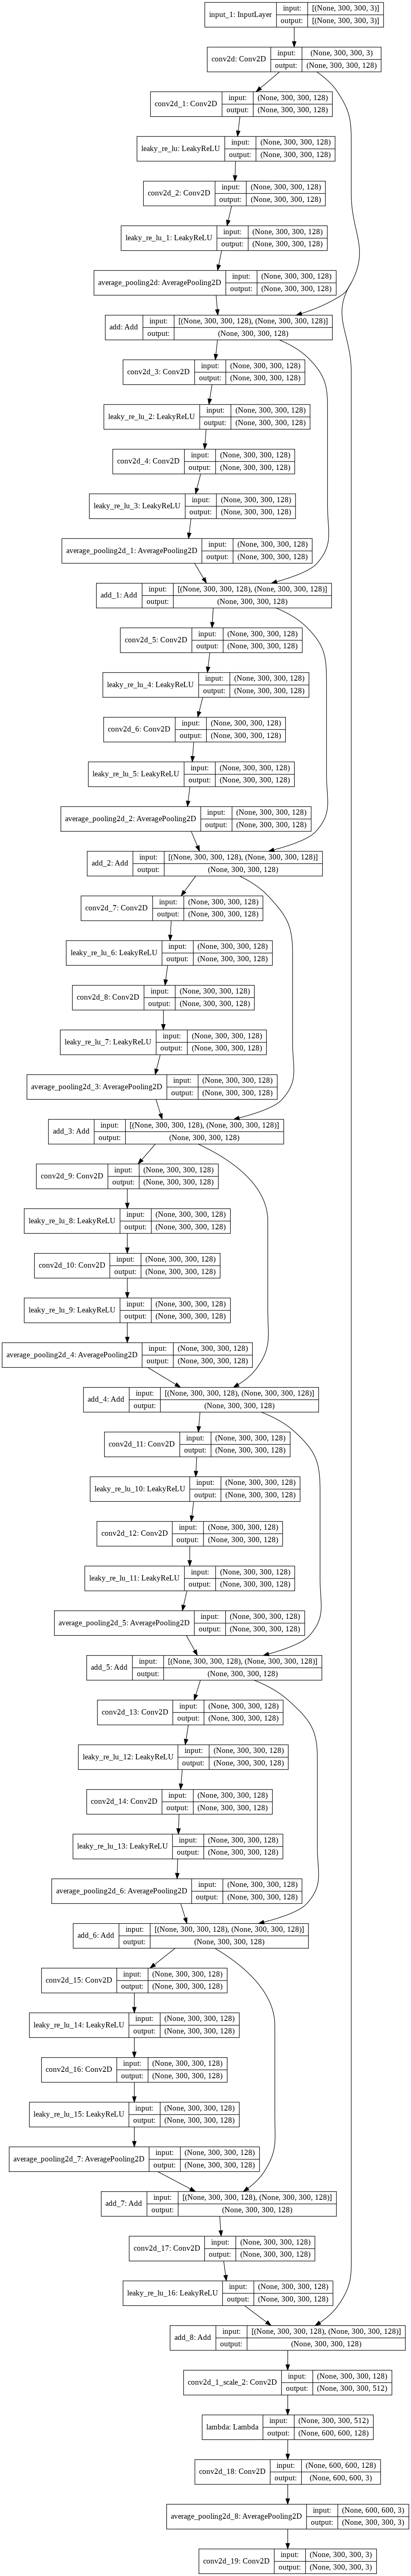

In [ ]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
plot_model(model=model, to_file='EDSRNetwork.png', show_shapes=True)

### Model architecture ends here

#### Data Augmentaion

In [4]:
#https://www.programcreek.com/python/example/102126/numpy.rot90
def data_aug(img, mode=0):
    '''
    function for data augmentation
    '''
    if mode == 0:
        return img
    elif mode == 1:
        return np.flipud(img)
    elif mode == 2:
        return np.rot90(img)
    elif mode == 3:
        return np.flipud(np.rot90(img))
    elif mode == 4:
        return np.rot90(img, k=2)
    elif mode == 5:
        return np.flipud(np.rot90(img, k=2))
    elif mode == 6:
        return np.rot90(img, k=3)
    elif mode == 7:
        return np.flipud(np.rot90(img, k=3))

#### The below function sorts the list based alpha numeric order

In [5]:
#https://stackoverflow.com/questions/4813061/non-alphanumeric-list-order-from-os-listdir#:~:text=To%20sort%20the%20result%2C%20use,listdir(path))%20.&text=You%20can%20now%20use%20this,dirlist%20%3D%20sorted_alphanumeric(os.
import re
def sorted_alphanumeric(data):
    '''
    sorts the list based on alpha numeric values
    '''
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

#### Train  data generator

In [6]:
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.geeksforgeeks.org/difference-between-yield-and-return-in-python/#:~:text=Difference%20between%20Python%20yield%20and%20Return&text=Yield%20is%20generally%20used%20to,result%20to%20the%20caller%20statement.&text=Yield%20statement%20function%20is%20executed,where%20the%20function%20get%20paused.
#https://stackoverflow.com/questions/59380430/how-to-use-model-fit-which-supports-generators-after-fit-generator-deprecation#:#~:text=fit%20which%20supports%20generators%20(after%20fit_generator%20deprecation),-python%20tensorflow%20keras&text=training)%20is%20deprecated%20and%20will,for%20updating%3A%20Please%20use%20Model.
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
def generator(batch_size=2,epoch=450,steps_per_epoch=200):
  '''
  function for train data generator which is fed to model.fit in keras
  '''
  while(True):
        list_of_pictures1=sorted_alphanumeric(os.listdir(root_path+'/resized_train_clean/'))[2000:3000]
        list_of_pictures2=sorted_alphanumeric(os.listdir(root_path+'/resized_train_noisy/'))[2000:3000]
       
        clean_arrays=[]
        noisy_arrays=[]
        for i in range(len(list_of_pictures1)):
                
                clean_array = img_to_array(load_img(root_path+'/resized_train_clean/'+list_of_pictures1[i]))/255
                noisy_array = img_to_array(load_img(root_path+'/resized_train_noisy/'+list_of_pictures2[i]))/255
                clean_arrays.append(clean_array)
                noisy_arrays.append(noisy_array)
                for k in range(3):
                  ran=np.random.randint(0,8)
                  clean_array=data_aug(clean_array,mode=ran)
                  noisy_array=data_aug(noisy_array,mode=ran)
                  clean_arrays.append(clean_array)
                  noisy_arrays.append(noisy_array)
        clean_arrays = np.array(clean_arrays).astype('float32')
        noisy_arrays = np.array(noisy_arrays).astype('float32')
        indices=list(range(clean_arrays.shape[0]))
        
        i=0
        for _ in range(epoch):
          np.random.shuffle(indices)    # shuffle
          while(i<clean_arrays.shape[0]):
            batch_clean_arrays = clean_arrays[indices[i:i+batch_size]]
            batch_noisy_arrays = noisy_arrays[indices[i:i+batch_size]]
            i=i+batch_size
            yield batch_noisy_arrays,batch_clean_arrays

### Test data generator 

In [8]:
def test_generator(batch_size=2,epoch=3,steps_per_epoch=6):
  '''
  function for test data generator which is fed to model.fit in keras
  '''
  while(True):
        list_of_pictures1=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))[0:200]
        list_of_pictures2=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))[0:200]
       
        clean_arrays=[]
        noisy_arrays=[]
        for i in range(len(list_of_pictures1)):
                
                clean_array = img_to_array(load_img(root_path+'/resized_test_clean/'+list_of_pictures1[i]))/255
                noisy_array = img_to_array(load_img(root_path+'/resized_test_noisy/'+list_of_pictures2[i]))/255
                clean_arrays.append(clean_array)
                noisy_arrays.append(noisy_array)
                for k in range(6):
                  ran=np.random.randint(0,8)
                  clean_array=data_aug(clean_array,mode=ran)
                  noisy_array=data_aug(noisy_array,mode=ran)
                  clean_arrays.append(clean_array)
                  noisy_arrays.append(noisy_array)
        clean_arrays = np.array(clean_arrays).astype('float32')
        noisy_arrays = np.array(noisy_arrays).astype('float32')
        indices=list(range(clean_arrays.shape[0]))
        
        i=0
        for _ in range(epoch):
          np.random.shuffle(indices)    # shuffle
          while(i<clean_arrays.shape[0]):
            batch_clean_arrays = clean_arrays[indices[i:i+batch_size]]
            batch_noisy_arrays = noisy_arrays[indices[i:i+batch_size]]
            i=i+batch_size
            yield batch_noisy_arrays,batch_clean_arrays

### Custom loss function 

In [9]:
#https://www.kdnuggets.com/2019/04/advanced-keras-constructing-complex-custom-losses-metrics.html
def sum_squared_error(y_true, y_pred):
    #return K.mean(K.square(y_pred - y_true), axis=-1)
    #return K.sum(K.square(y_pred - y_true), axis=-1)/2
    return K.sum(K.square(y_pred - y_true))/2

#### Loading last epoch model where last interruption occured. This loaded model remebers the last epoch executed and starts from there

In [10]:
#https://stackoverflow.com/questions/52476191/what-does-initial-epoch-in-keras-mean/52478034#:~:text=initial_epoch%3A%20Integer.,if%20I'm%20wrong).
def initial_epochs():
  '''
  This function understands till what epoch model has executed untill last interuption happened
  ''' 
  list_of_epochs=[]
  filepaths=glob.glob('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/*')
  if(not filepaths):
    return 0
  for path in filepaths:
    splitted=path.split('epochs')[1]
    epoch_num=int(splitted.split('.')[0])
    list_of_epochs.append(epoch_num)
  last_epoch=max(list_of_epochs)
  return last_epoch

In [11]:
#https://stackoverflow.com/questions/52476191/what-does-initial-epoch-in-keras-mean/52478034#:~:text=initial_epoch%3A%20Integer.,if%20I'm%20wrong).
initial_epoch_ = initial_epochs()

In [13]:
if(initial_epoch_>0):
  model=keras.models.load_model('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs%03d.hdf5'%initial_epoch_,compile=False)

#### Compiling

In [14]:
#compiling the model
model.compile(loss=sum_squared_error,
              optimizer = Adam(0.0001))

##### Set of keras callbacks

In [15]:
#https://keras.io/api/callbacks/model_checkpoint/
#https://keras.io/api/callbacks/model_checkpoint/
#https://machinelearningmastery.com/check-point-deep-learning-models-keras/
#https://keras.io/api/callbacks/reduce_lr_on_plateau/
#https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/#:~:text=Early%20stopping%20is%20a%20method,deep%20learning%20neural%20network%20models.
model_save=ModelCheckpoint(
    'drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs{epoch:03d}.hdf5',
    monitor="val_loss",
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode="min",
    save_freq=int(20*150))
#https://keras.io/api/callbacks/learning_rate_scheduler/
'''def scheduler(epoch):
      
      changing initial learning rate for adams optimizer
      
      lri=0.00002
      if epoch < 270:
        lr=lri
        return lr
      elif (epoch <300):
        lr=0.000001
        return lr
      elif (epoch<350):
        lr=0.0000001
        return lr
      elif (epoch<400):
        lr=0.00000001
        return lr
      else:
        lr=0.00000001
        return lr
learning_rate_scheduler=tf.keras.callbacks.LearningRateScheduler(scheduler)'''
learning_rate_scheduler=ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.7,
    patience=100,
    verbose=1,
    mode="min",
    min_delta=0.0001,
    min_lr=1e-11
)

early_stopping=EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=100,
    verbose=1,
    mode="min"
)

callbacklist=[model_save,learning_rate_scheduler,early_stopping]

#### Fitting the model

In [16]:
model.fit(generator(2,150,300),validation_data=test_generator(2,3,6),verbose=1,steps_per_epoch=150, epochs=1000,initial_epoch=initial_epoch_,callbacks=callbacklist,validation_steps=6,
    validation_batch_size=2)

Epoch 501/1000
150/150 [==============================] - 41s 238ms/step - loss: 1506.4517 - val_loss: 4967.6646
Epoch 502/1000
150/150 [==============================] - 33s 222ms/step - loss: 1381.3447 - val_loss: 7880.4531
Epoch 503/1000
150/150 [==============================] - 34s 223ms/step - loss: 1727.9625 - val_loss: 4301.9360
Epoch 504/1000
150/150 [==============================] - 34s 223ms/step - loss: 1319.3432 - val_loss: 3555.9304
Epoch 505/1000
150/150 [==============================] - 33s 223ms/step - loss: 1085.2362 - val_loss: 8565.5400
Epoch 506/1000
150/150 [==============================] - 33s 223ms/step - loss: 1291.5290 - val_loss: 7804.5190
Epoch 507/1000
150/150 [==============================] - 34s 224ms/step - loss: 1420.2911 - val_loss: 3881.0808
Epoch 508/1000
150/150 [==============================] - 33s 223ms/step - loss: 1342.8017 - val_loss: 8030.7271
Epoch 509/1000
150/150 [==============================] - 34s 224ms/step - loss: 1138.6045 - val

### list of things tried with the above architecture.
<ul>
<li>
Used different initial learning rates for adams optimizer when used 0.0001 as learning rate result was changing abruptly with every epoch . Then changed this to 0.00001 stabilized the result 
</li>
<li>
Tried different loss function including custom ssim and custom psnr loss ,but these did not work well may be because of they work on image level . Only square loss worked well.
</li>
<li>
Initially it was overfitting then reduced the architecture complexity,introduced l2 normalization to both bias term and main part. Added dropouts which was helpful to reduce the overfitting little bit. 
</li>
<li>
Tried with different batch sizes . Batch size 3 showed better performance.
</li>
</ul>

#### Validating test data with PSNR score and SSIM score

In [ ]:
#model = keras.models.load_model(root_path+'/model_mrdn2/'+'denoiser_epochs087.hdf5',compile=False)
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
list_noisy=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))
psnr_clean_noisy=[]
ssim_clean_noisy=[]
psnr_clean_predicted=[]
ssim_clean_predicted=[]
for file in tqdm(list_clean):
  clean = img_to_array(load_img(root_path+'/resized_test_clean/'+file))
  noisy = img_to_array(load_img(root_path+'/resized_test_noisy/'+file))
  image_predicted = model.predict(np.expand_dims(noisy/255,axis=0))
  predicted=img_to_array(array_to_img(image_predicted[0]))
  psnr_clean_noisy.append(peak_signal_noise_ratio(clean,noisy,data_range=255))
  ssim_clean_noisy.append(structural_similarity(clean,noisy,data_range=255,multichannel=True))
  psnr_clean_predicted.append(peak_signal_noise_ratio(clean,predicted,data_range=255))
  ssim_clean_predicted.append(structural_similarity(clean,predicted,data_range=255,multichannel=True))
length=len(list_clean)
psnr_clean_noisy_avg=sum(psnr_clean_noisy)/length
ssim_clean_noisy_avg=sum(ssim_clean_noisy)/length
psnr_clean_predicted_avg=sum(psnr_clean_predicted)/length
ssim_clean_predicted_avg=sum(ssim_clean_predicted)/length

In [ ]:
print('Clean and noisy images average psnr=',psnr_clean_noisy_avg)
print('Clean and noisy images average ssim=',ssim_clean_noisy_avg)
print('Clean and predicted image average psnr=',psnr_clean_predicted_avg)
print('Clean and predicted image average  ssim=',ssim_clean_predicted_avg)

In [ ]:
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
length=len(list_clean)

psnr_clean_noisy=[]
ssim_clean_noisy=[]

for file in os.listdir('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/'):
  model=keras.models.load_model('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/'+file,compile=False)
  print('drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/'+file)
  psnr_clean_predicted=[]
  ssim_clean_predicted=[]
  for file in tqdm(list_clean):
    clean = img_to_array(load_img(root_path+'/resized_test_clean/'+file))
    noisy = img_to_array(load_img(root_path+'/resized_test_noisy/'+file))
    image_predicted = model.predict(np.expand_dims(noisy/255,axis=0))
    predicted=img_to_array(array_to_img(image_predicted[0]))
    psnr_clean_predicted.append(peak_signal_noise_ratio(clean,predicted,data_range=255))
    ssim_clean_predicted.append(structural_similarity(clean,predicted,data_range=255,multichannel=True))
  psnr_clean_predicted_avg=sum(psnr_clean_predicted)/length
  print(psnr_clean_predicted_avg)
  ssim_clean_predicted_avg=sum(ssim_clean_predicted)/length
  print(ssim_clean_predicted_avg)

drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs010.hdf5



23.092682720208195
0.7197529476536205
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs020.hdf5



23.304290505109382
0.750369709848864
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs030.hdf5



24.28982028823537
0.7587571953913118
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs040.hdf5



24.42508307693602
0.7623921396751957
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs050.hdf5



24.737334210245983
0.7652296540230241
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs060.hdf5



24.87861827825204
0.7697063456907525
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs070.hdf5



25.164844797393737
0.777226457267758
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs080.hdf5



25.37421930214185
0.7758627239593123
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs090.hdf5



25.1802839701522
0.7775830667161483
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs100.hdf5



25.83392405990096
0.7838274982779211
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs110.hdf5



25.57956724390887
0.785555469656705
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs120.hdf5



25.664770918669365
0.7891584418700098
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs130.hdf5



25.92473831023276
0.7895086569391443
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs140.hdf5



26.127425463694966
0.7902733954438333
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs150.hdf5



26.40291006537502
0.790763145728125
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs160.hdf5



26.392411553290167
0.7909632176300376
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs170.hdf5



26.478845200493787
0.7903616434916905
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs180.hdf5



26.456290103643312
0.7911558804901784
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs190.hdf5



26.404272107775615
0.7927318113044839
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs200.hdf5



26.45463063069579
0.7911878251454179
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs210.hdf5



26.445749452175818
0.7924051524102006
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs220.hdf5



26.468511731248174
0.791874777585565
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs226.hdf5



26.44674646318317
0.7927725397291818
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs236.hdf5



26.489358912466344
0.7925353947711249
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs246.hdf5



26.453699655537243
0.7923853241558285
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs256.hdf5



26.465143204286296
0.7925624649714458
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs266.hdf5



26.459867693295518
0.7926711093504792
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs276.hdf5



26.462081198662702
0.7926590482296619
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs286.hdf5



26.471933800270087
0.7926615593699957
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs296.hdf5



26.471148218853806
0.7926656934644696
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs298.hdf5



26.508385724870987
0.7932231800035131
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs009.hdf5



26.382326314323297
0.7934799461229926
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs019.hdf5



26.494861427497334
0.7930534517514356
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs029.hdf5



26.53287278775061
0.7935380826766666
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs039.hdf5



26.469737515699922
0.7939207316375023
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs049.hdf5



26.502686122402725
0.7942786389319327
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs059.hdf5



26.59854516721479
0.7948767492843503
drive/MyDrive/Colab Notebooks/noise_clean_data/dataset/model_edsrp/denoiser_epochs069.hdf5



26.457527952090317
0.7939717324590314


### Displaying images noisy ,clean and predicted

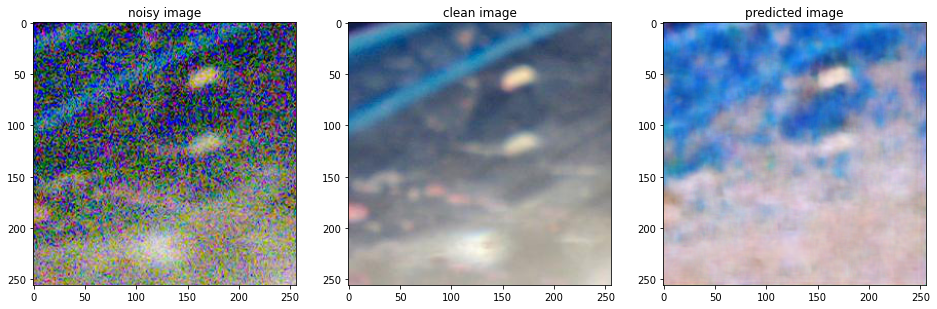

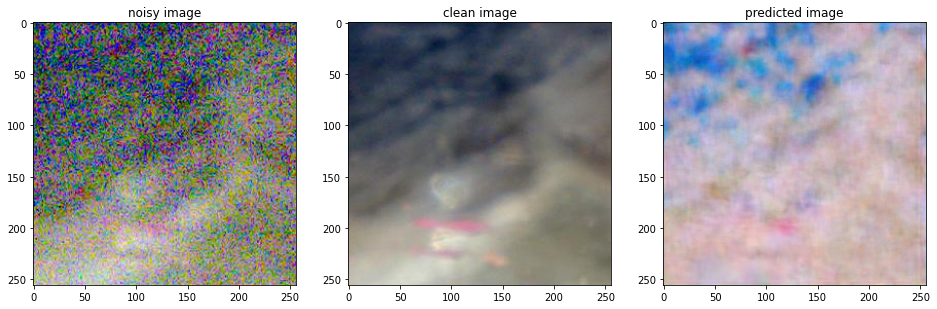

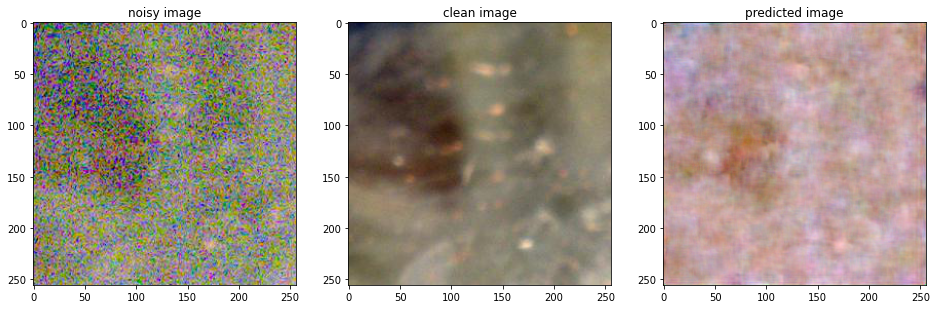

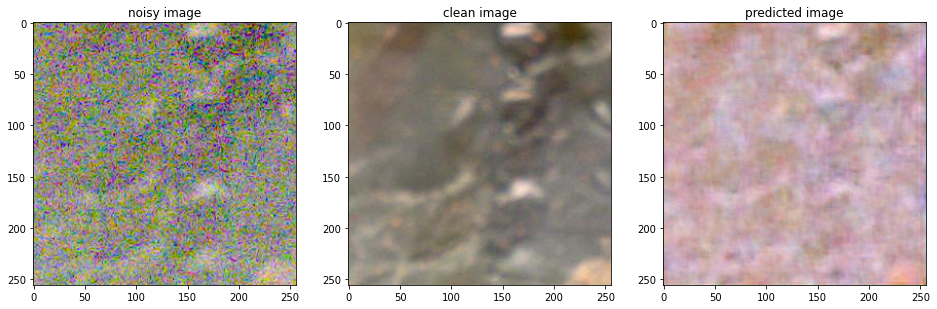

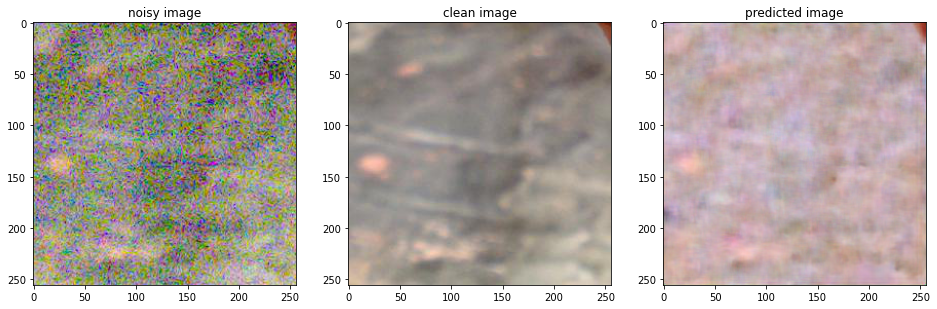

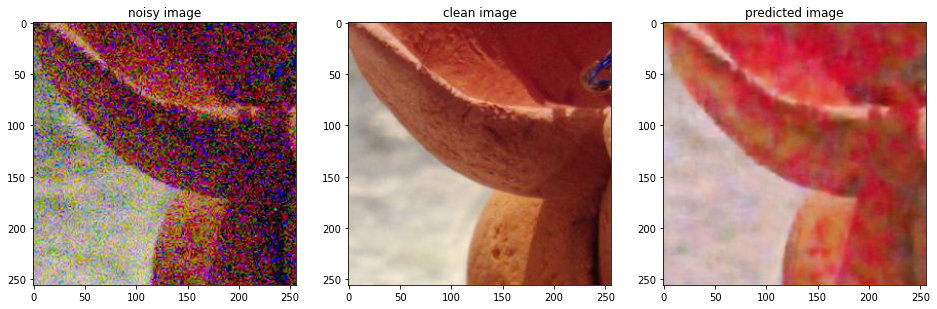

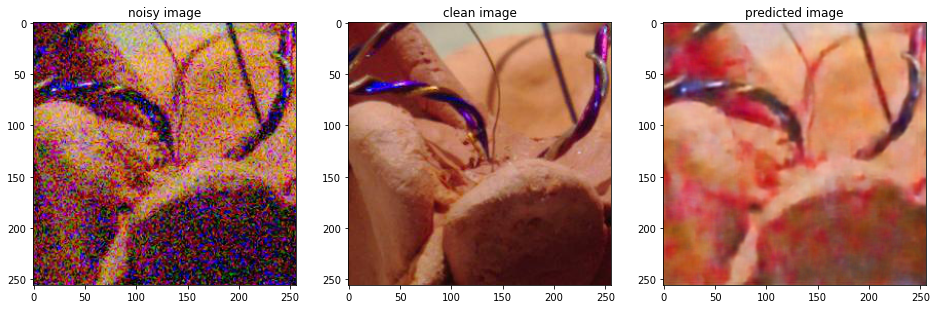

In [17]:
#model = keras.models.load_model(root_path+'/model_mrdn2/'+'denoiser_epochs040.hdf5',compile=False)
list_clean=sorted_alphanumeric(os.listdir(root_path+'/resized_test_clean/'))
list_noisy=sorted_alphanumeric(os.listdir(root_path+'/resized_test_noisy/'))
for file in list_clean[100:107]:
  image_clean=load_img(root_path+'/resized_test_clean/'+file,target_size=(256,256)) 
  image_noise=load_img(root_path+'/resized_test_noisy/'+file,target_size=(256,256))
  image_predicted = model.predict(np.expand_dims(img_to_array(image_noise)/255,axis=0))
  predicted_image = array_to_img(image_predicted[0])

  plt.figure(figsize=(16, 12))
  plt.subplot(131)
  plt.title('noisy image')
  plt.imshow(image_noise)

  plt.subplot(132)
  plt.title('clean image')
  plt.imshow(image_clean)

  plt.subplot(133)
  plt.title('predicted image')
  plt.imshow(predicted_image)

In [ ]:
#https://pypi.org/project/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["model", "psnr_clean_noisy", "psnr_clean_predicted",'psnr improvement from model', "ssim_clean_noisy",'ssim_clean_predicted','ssim improvement from model']
x.add_row(["baseline_DnCNN(8 data points taken)", 25.77 ,27.14   ,np.round(27.14 - 25.77,2), 0.7632 , 0.7793  ,np.round(0.7793-0.7632,3)])
x.add_row(["MRDN(10 datapoints taken)", np.round(psnr_clean_noisy_avg,2),np.round(psnr_clean_predicted_avg,2),np.round(psnr_clean_predicted_avg-psnr_clean_noisy_avg,2), np.round(ssim_clean_noisy_avg,4), np.round(ssim_clean_predicted_avg,4),np.round(ssim_clean_predicted_avg-ssim_clean_noisy_avg,4)])

print(x)

### Conclusion and final points: MRDN model is showing better improvements interms of ssim and psnr compared to baseline_DnCNN like model. In the actual competion Samsung team trains MRDN model for 7 days and on large number of data. As I have limited resources trained it on 633 different data points and applied  image augmentation on it. Trained it for 3 to 4 hours. I feel that there is goood improvements interms of SSIM value compared to PSNR.

In [ ]:
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
#https://www.geeksforgeeks.org/difference-between-yield-and-return-in-python/#:~:text=Difference%20between%20Python%20yield%20and%20Return&text=Yield%20is%20generally%20used%20to,result%20to%20the%20caller%20statement.&text=Yield%20statement%20function%20is%20executed,where%20the%20function%20get%20paused.
#https://stackoverflow.com/questions/59380430/how-to-use-model-fit-which-supports-generators-after-fit-generator-deprecation#:#~:text=fit%20which%20supports%20generators%20(after%20fit_generator%20deprecation),-python%20tensorflow%20keras&text=training)%20is%20deprecated%20and%20will,for%20updating%3A%20Please%20use%20Model.
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit